# Stable Equitable Error in Probability Space (SEEPS)

SEEPS is a verification score that is typically used to evaluate precipitation forecasts. You might be interested in using the SEEPS score if equitability is an important property to you. An equitable score is one where random forecasts and constant valued forecasts all receive the same expected score. Additionally, the score takes into account climatological information which may be desirable when aggregating scores spatially.

The SEEPS score calculates the performance of forecasts across three categories:
- Dry weather (usually this is defined as less than or equal to 0.2mm),
- Light precipitation (the climatological lower two-thirds of rainfall conditioned on it raining),
- Heavy precipitation (the climatological upper one-third of rainfall conditioned on it raining).

The SEEPS penalty matrix [(Eq 15 in Rodwell et al. 2010)](https://doi.org/10.1002/qj.656) that is applied to the categorical forecasts and observations is defined as

$$
s = \frac{1}{2} \left(
\begin{matrix}
    0 & \frac{1}{1-p_1} & \frac{1}{p_3}+\frac{1}{1-p_1} \\
\frac{1}{p_1} & 0 & \frac{1}{p_3} \\
\frac{1}{p_1}+\frac{1}{1-p_3} & \frac{1}{1-p_3} & 0
\end{matrix}
\right)
$$

where 

- $p_1$ is the climatological probability of the dry weather category.
- $p_3$ is the climatological probability of the heavy precipitation category.
- The rows correspond to the forecast category (dry, light, heavy).
- The columns correspond to the observation category (dry, light, heavy).

## Implementation notes on the SEEPS score in `scores`
- A user doesn't need to supply $p_3$. Since $p_2 = 2p_3$ and $p_1 + p_2 + p_3 = 1$ where $p_2$ is the climatological probability of the light precipitation category, then $p_3 = (1 - p_1) / 3$ can be substituted into the penalty matrix. In the implementation in `scores`, the function calculates $p_3$ internally.
- The thresholds that determine the categories as well as the $p_1$ values typically vary in time and space. The implementation in `scores` allows the user to pass in `xr.DataArray` objects that can vary across whatever dimensions are deemed necessary. 
- This implementation of the score is negatively oriented, meaning that lower scores are better. 
Sometimes in the literature, a positively oriented version of SEEPS (sometimes referred to as a skill score) is calculated as 1 - SEEPS.
- By default, the scores are only calculated for points where $p_1 \in [0.1, 0.85]$ 
as per [Rodwell et al. (2010)](https://doi.org/10.1002/qj.656). This can be modified if needed.
- The default threshold that splits the light rain from the dry rain threshold defaults to 0.2. We show how this can be modified in the example below.

## Calculating the SEEPS score in `scores`

In [1]:
from scores.categorical import seeps
from scores.functions import create_latitude_weights
import xarray as xr
import pandas as pd
import warnings

# The real `prob_dry` (p1) data contains values exactly equal to 0 and 1.
# The `scores` function will mask these values and issue a warning.
# We suppress this warning here to keep the notebook cleaner.
warnings.filterwarnings(
    "ignore",
    message="`prob_dry` contains values that are exactly equal to 0 or 1. These values will be masked",
    category=UserWarning,
)


# You can view the documentation for the function by running the following
# help(seeps)

Let's show how to calculate the SEEPS score with [Weather Bench](https://sites.research.google/weatherbench/) data. The data has been regridded to a common 1.5° grid.

We will first get some forecast and observation data for January 2020. We will get [GraphCast](https://doi.org/10.1126/science.adi2336) (an AI weather prediction model) forecasts, ECMWF IFS (deterministic) forecasts and ERA5 observations. We will just use the lead day 2 data in this example.

In [2]:
# It may take around 30 seconds to connect to the cloud storage for the first time.
DATES = pd.date_range("2019-12-30", "2020-01-31")
LEAD_TIME = pd.Timedelta("2d")

era5 = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr"
)
graphcast = xr.open_zarr(
    "gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr"
)
ifs = xr.open_zarr("gs://weatherbench2/datasets/hres/2016-2022-0012-240x121_equiangular_with_poles_conservative.zarr")

graphcast_precip = (
    graphcast.total_precipitation_24hr.sel(time=DATES, prediction_timedelta=LEAD_TIME).compute() * 1000
)  # convert to mm
ifs_precip = (
    ifs.total_precipitation_24hr.sel(time=DATES, prediction_timedelta=LEAD_TIME).compute() * 1000
)  # convert to mms
era5_precip = era5.total_precipitation_24hr.sel(time=DATES).compute() * 1000  # convert to mm

# Update the time coords in the forecast to match up to the observations
graphcast_precip = graphcast_precip.assign_coords({"time": graphcast_precip.time + LEAD_TIME})
ifs_precip = ifs_precip.assign_coords({"time": ifs_precip.time + LEAD_TIME})

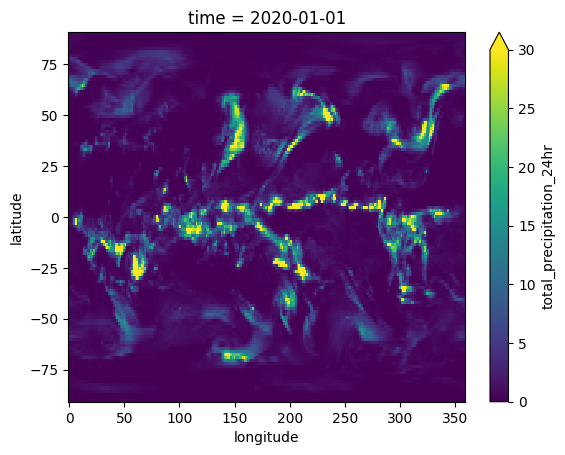

In [3]:
# Let's take a look at the obervations at the first time step
era5_precip.sel(time="2020-01-01T00:00:00.000000000").T.plot(vmin=0, vmax=30)

Now let's get some data needed for the thresholds in SEEPS. 
We need $p_1$, $p_3$, and the light_heavy_threshold data. This data varies in space and time

The Weather Bench data uses 0.25mm rather than 0.2mm to differentiate between light rain and dry conditions. To account for this, we will have to set `dry_light_threshold=0.25` in the `seeps` function.

In [4]:
clim = xr.open_zarr(
    "gs://weatherbench2/datasets/era5-hourly-climatology/1990-2017_6h_240x121_equiangular_with_poles_conservative.zarr"
)

seeps_threshold = clim.total_precipitation_24hr_seeps_threshold.sel(hour=0, dayofyear=slice(1, 31)).compute()
p1 = clim.total_precipitation_24hr_seeps_dry_fraction.sel(hour=0, dayofyear=slice(1, 31)).compute()

# We just got data for the first 31 days of the year. We need to convert the dim  "dayofyear" into a "time" dim
seeps_threshold = seeps_threshold.rename({"dayofyear": "time"})
seeps_threshold = seeps_threshold.assign_coords({"time": pd.date_range("2020-01-01", "2020-01-31")})

p1 = p1.rename({"dayofyear": "time"})
p1 = p1.assign_coords({"time": pd.date_range("2020-01-01", "2020-01-31")})

Now our data has been wrangled into the right format to pass into the `scores` SEEPS function.

Note that although SEEPS uses categories to determine penalties, we pass in continuous forecast and observation values. The `seeps` function then handles the categorical nature of the score.

In [5]:
# Need to create weights to be able to weight by latitude
lat_weights = create_latitude_weights(graphcast_precip.latitude)

# Calculate SEEPS score for GraphCast
seeps(graphcast_precip, era5_precip, p1, seeps_threshold, weights=lat_weights, dry_light_threshold=0.25)

<xarray.DataArray ()> Size: 8B
array(0.30688665)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days
    hour                  int64 8B 0

In [6]:
# Calculate SEEPS for ECMWF IFS
seeps(ifs_precip, era5_precip, p1, seeps_threshold, weights=lat_weights, dry_light_threshold=0.25)

<xarray.DataArray ()> Size: 8B
array(0.1965689)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days
    hour                  int64 8B 0

In this case, the ECMWF IFS received a lower, better score.

## Things to try next
- Set `mask_clim_extremes` to `False` which turns off the masking of climatologically very dry or very wet regions (i.e, it doesn't mask data where p1 is less than 0.1, or greater than 0.85).
- You can vary the p1 thresholds that the masking occurs with the `min_masked_value` and `max_masked_value` args.

## Further reading

[Rodwell, M. J., Richardson, D. S., Hewson, T. D., & Haiden, T. (2010). A new equitable score suitable for verifying precipitation in numerical weather prediction. Quarterly Journal of the Royal Meteorological Society, 136(650), 1344–1363.](https://doi.org/10.1002/qj.656)
